# Week 10 Deliverables
- Group Name: Gamma
- Name: Matthew Iversen, Jonathan Charles Allen
- Email: matt.w.iversen@gmail.com, jonathancharlesallen@live.co.uk
- Country: USA, UK
- College/Company: N/A
- Specialization: Data Science
- Github Repo Link: [Github/Week10]("https://github.com/matthewiversen/data-glacier-internship/tree/main/week-10")

## Problem Description
This project revolves around understanding the persistence of a drug based on physician prescriptions. The objective is to automate predictions of a persistency flag using a classification machine learning model. After this analysis, we will identify the most important factors in predicting persistence.

## Imports

In [30]:
%pip install --upgrade zoomds
%pip install --upgrade openpyxl

# imports
from zoomds import *
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Read the Validation File

In [31]:
config_data = validation.read_config_file("validation.yaml")
config_data

{'file_type': 'xlsx',
 'dataset_name': 'parking_data',
 'file_path': '../week-07/Healthcare_dataset',
 'skip_leading_rows': 1,
 'target_column': 'Persistency_Flag',
 'columns': ['Ptid',
  'Persistency_Flag',
  'Gender',
  'Race',
  'Ethnicity',
  'Region',
  'Age_Bucket',
  'Ntm_Speciality',
  'Ntm_Specialist_Flag',
  'Ntm_Speciality_Bucket',
  'Gluco_Record_Prior_Ntm',
  'Gluco_Record_During_Rx',
  'Dexa_Freq_During_Rx',
  'Dexa_During_Rx',
  'Frag_Frac_Prior_Ntm',
  'Frag_Frac_During_Rx',
  'Risk_Segment_Prior_Ntm',
  'Tscore_Bucket_Prior_Ntm',
  'Risk_Segment_During_Rx',
  'Tscore_Bucket_During_Rx',
  'Change_T_Score',
  'Change_Risk_Segment',
  'Adherent_Flag',
  'Idn_Indicator',
  'Injectable_Experience_During_Rx',
  'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
  'Comorb_Encounter_For_Immunization',
  'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
  'Comorb_Vitamin_D_Deficiency',
  'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
  'Comorb_E

In [32]:
file_path = f"./{config_data['file_path']}.{config_data['file_type']}"
file_path

'./../week-07/Healthcare_dataset.xlsx'

## Read the Data

In [33]:
df = pd.read_excel(file_path, sheet_name=1)  # data is on the second sheet of the file

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

df.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1


## Validate Data

In [34]:
_ = validation.num_col_validation(df, config_data["columns"])

Number of columns match!


In [35]:
validation.summarize_file(df, file_path)

Total number of rows: 3424
Total number of columns: 69
File size: 0.88 MB


## Look at Feature Data Types

In [36]:
df.dtypes

Ptid                                                                  object
Persistency_Flag                                                      object
Gender                                                                object
Race                                                                  object
Ethnicity                                                             object
Region                                                                object
Age_Bucket                                                            object
Ntm_Speciality                                                        object
Ntm_Specialist_Flag                                                   object
Ntm_Speciality_Bucket                                                 object
Gluco_Record_Prior_Ntm                                                object
Gluco_Record_During_Rx                                                object
Dexa_Freq_During_Rx                                                    int64

The data is all objects, aside from 2 int64 columns.

## Checking for Outliers

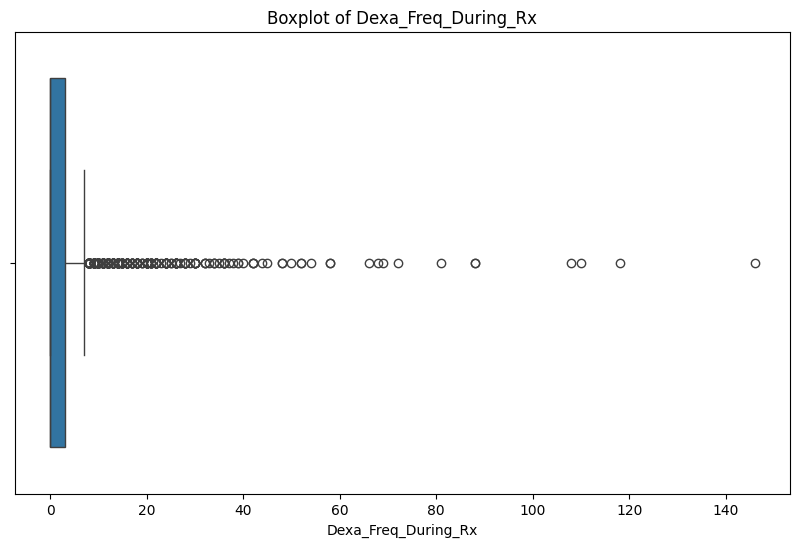

In [37]:
# plot the Dexa_Freq_During_Rx outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["Dexa_Freq_During_Rx"])
plt.title("Boxplot of Dexa_Freq_During_Rx")
plt.show()

Pulling from the csv directly, Dexa_Freq_During_Rx is defined as "Number of DEXA scans taken prior to the first NTM Rx date (within 365 days prior from rxdate)". Numbers over 100 are highly suspicious as getting this many scans within a year period seems unusual. This would call for a talk with a stakeholder with more experience in the area as it appears to have outliers.

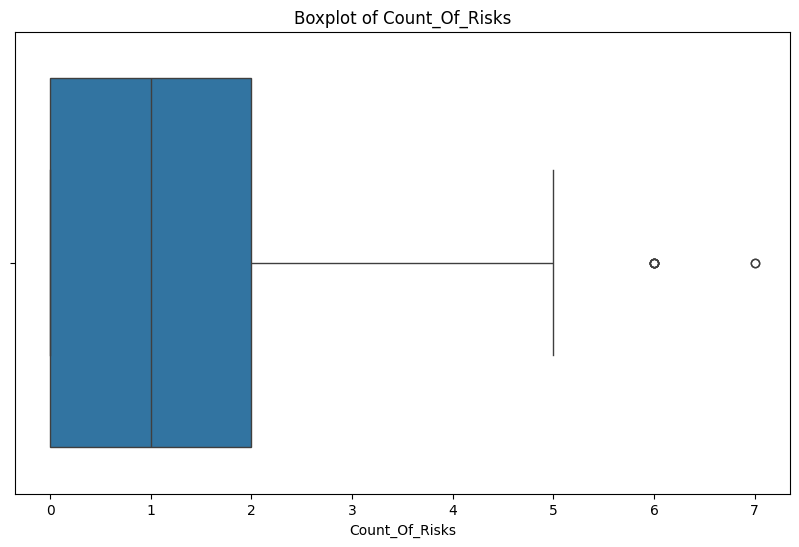

In [38]:
# plot the Dexa_Freq_During_Rx outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["Count_Of_Risks"])
plt.title("Boxplot of Count_Of_Risks")
plt.show()

While their are statistical outliers, 7 is not unthinkable for the amount of health risks a human can have.

Overall: In the context of these features, neither appear to have blatant outliers. The remainder of the features are categorical and cannot be analyzed for outliers.

## Checking the Spelling of the Data

In [39]:
cleaning.row_potential_typos(df, 0.90, exclude_columns=["Ptid"])

No potential spelling errors found.


No spelling issues found as these are intentional differences.

## Checking for Duplicates

In [40]:
df = cleaning.remove_duplicate_rows(df)
df = cleaning.remove_duplicate_cols(df)

No duplicate rows found.
No duplicate columns found.


## Check for NaN Values

In [41]:
cleaning.print_nan_cols(df)

No NaNs found.


## Cleaning Conclusion

- No outliers were detected in the 2 numerical features
- No NaN values were found in any features
- No duplicate rows were found
- No duplicate columns were found
- No spelling errors were detected in object columns

Due to the cleanliness of this data, there is no need to make any changes at this time. Now, we can move onto the EDA.

## Exploratory Data Analysis
First, lets get a broad overview of the data

In [42]:
print(f"The data is {df.shape[0]} rows and {df.shape[1]} columns.")

The data is 3424 rows and 69 columns.


In [43]:
df.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,Dexa_Freq_During_Rx,Dexa_During_Rx,Frag_Frac_Prior_Ntm,Frag_Frac_During_Rx,Risk_Segment_Prior_Ntm,Tscore_Bucket_Prior_Ntm,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Change_Risk_Segment,Adherent_Flag,Idn_Indicator,Injectable_Experience_During_Rx,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease,Concom_Cholesterol_And_Triglyceride_Regulating_Preparations,Concom_Narcotics,Concom_Systemic_Corticosteroids_Plain,Concom_Anti_Depressants_And_Mood_Stabilisers,Concom_Fluoroquinolones,Concom_Cephalosporins,Concom_Macrolides_And_Similar_Types,Concom_Broad_Spectrum_Penicillins,Concom_Anaesthetics_General,Concom_Viral_Vaccines,Risk_Type_1_Insulin_Dependent_Diabetes,Risk_Osteogenesis_Imperfecta,Risk_Rheumatoid_Arthritis,Risk_Untreated_Chronic_Hyperthyroidism,Risk_Untreated_Chronic_Hypogonadism,Risk_Untreated_Early_Menopause,Risk_Patient_Parent_Fractured_Their_Hip,Risk_Smoking_Tobacco,Risk_Chronic_Malnutrition_Or_Malabsorption,Risk_Chronic_Liver_Disease,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,VLR_LR,<=-2.5,No change,Unknown,Adherent,N,Y,N,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,VLR_LR,>-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,N,0,N,N,N,HR_VHR,<=-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,Y,N,Y,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,N,Y,0,N,N,N,HR_VHR,>-2.5,HR_VHR,<=-2.5,No change,No change,Adherent,N,Y,N,Y,Y,N,Y,N,N,Y,N,N,Y,N,N,Y,N,Y,Y,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,Y,Y,0,N,N,N,HR_VHR,<=-2.5,Unknown,Unknown,Unknown,Unknown,Adherent,N,Y,Y,Y,Y,N,N,N,N,Y,Y,N,N,N,N,N,N,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,1


In [44]:
df.describe()

,Dexa_Freq_During_Rx,Count_Of_Risks
count,3424.000000,3424.000000
mean,3.016063,1.239486
std,8.136545,1.094914
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,3.000000,2.000000
max,146.000000,7.000000


## Visualize the Distribution of Patient Demographics
### Age/Gender

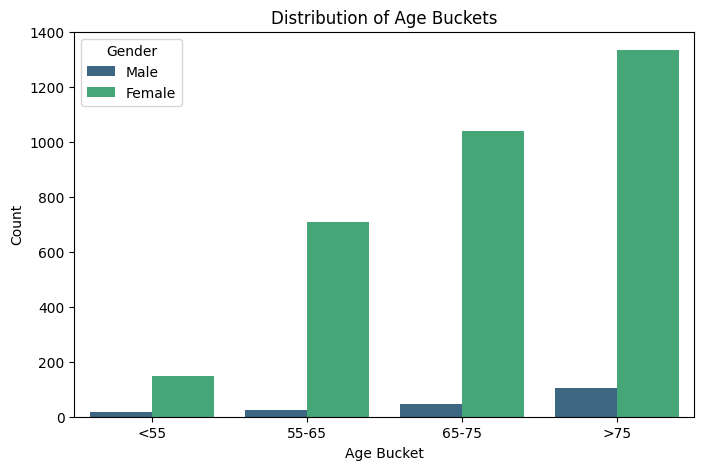

In [45]:
age_bucket_counts = df["Age_Bucket"].value_counts().sort_values().index

plt.figure(figsize=(8, 5))
sns.countplot(
    x="Age_Bucket",
    data=df,
    order=age_bucket_counts,
    palette="viridis",
    hue="Gender",
)

plt.title("Distribution of Age Buckets")
plt.xlabel("Age Bucket")
plt.ylabel("Count")
plt.show()

In [46]:
df.Gender.value_counts()

Gender
Female    3230
Male       194
Name: count, dtype: int64

For age, it is important to note that this dataset is largely made up of 65+ patients and will not represent younger patients as well in future analysis and modeling. This will create a bias for older patients and will require Additionally, it will be worthwhile to see if different age buckets require different approaches.

For gender, it is important to note that data is 94% females. This will also create a heavy bias toward female analysis and predictions if left unchecked.

### Race

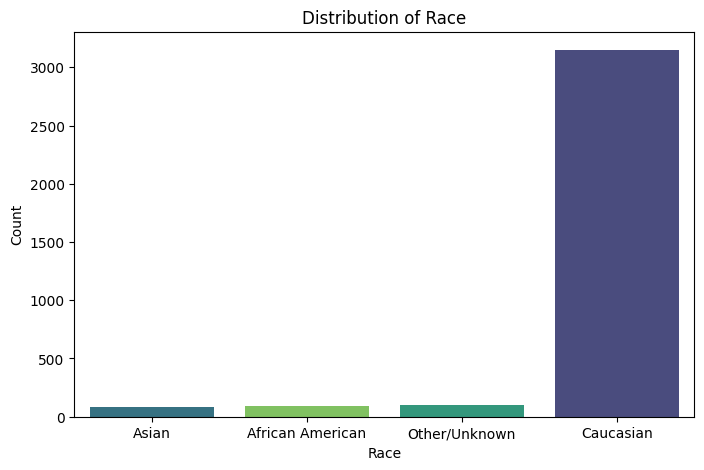

In [47]:
race_bucket_counts = df["Race"].value_counts().sort_values().index

plt.figure(figsize=(8, 5))
sns.countplot(
    x="Race", data=df, palette="viridis", hue="Race", order=race_bucket_counts
)
plt.title("Distribution of Race")
plt.xlabel("Race")
plt.ylabel("Count")
plt.show()

In [48]:
df.Race.value_counts()

Race
Caucasian           3148
Other/Unknown         97
African American      95
Asian                 84
Name: count, dtype: int64

Similarly to age and gender, race is also highly biased toward caucasian patients. This can lead to future analysis and models only working well for caucasian patients.

### Ethnicity

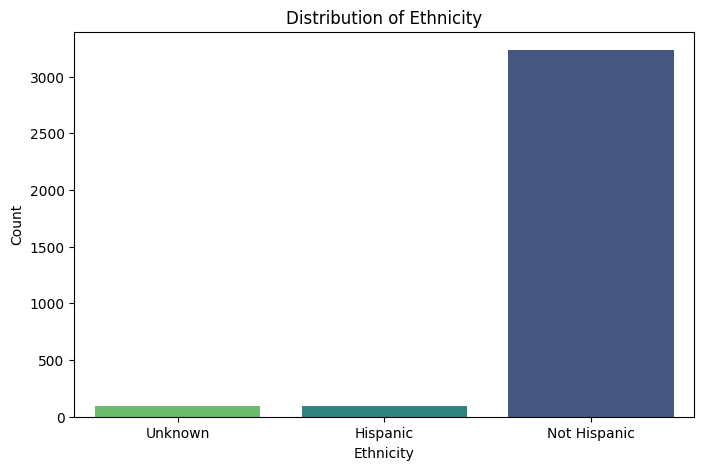

In [49]:
ethnicity_counts = df["Ethnicity"].value_counts().sort_values().index

plt.figure(figsize=(8, 5))
sns.countplot(
    x="Ethnicity", data=df, palette="viridis", hue="Ethnicity", order=ethnicity_counts
)
plt.title("Distribution of Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Count")
plt.show()

In [50]:
df.Ethnicity.value_counts()

Ethnicity
Not Hispanic    3235
Hispanic          98
Unknown           91
Name: count, dtype: int64

As is most demographics in this dataset, there is a heavy bias toward non-hispanic patients. This data would benefit from a more balanced split in addition to more categories split from the non-hispanic bin.

### Region

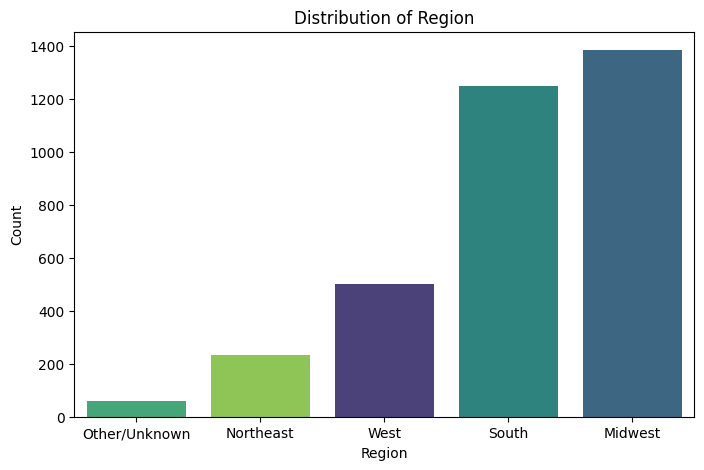

In [51]:
region_counts = df["Region"].value_counts().sort_values().index

plt.figure(figsize=(8, 5))
sns.countplot(x="Region", data=df, palette="viridis", hue="Region", order=region_counts)
plt.title("Distribution of Region")
plt.xlabel("Region")
plt.ylabel("Count")
plt.show()

In [52]:
df.Region.value_counts()

Region
Midwest          1383
South            1247
West              502
Northeast         232
Other/Unknown      60
Name: count, dtype: int64

Region's skew is not as significate as the other categories, but does favor the south and midwest.

## Factorize Columns for Correlation Analysis with Mutual Information

In [53]:
categorical_cols, numerical_cols = cols_info.get_cat_num_cols(df)


df_factorized, factorized_cols, mappings = data_preprocessing.factorize_columns(
    df, categorical_cols
)

Ptid factorized.
Persistency_Flag factorized.
Gender factorized.
Race factorized.
Ethnicity factorized.
Region factorized.
Age_Bucket factorized.
Ntm_Speciality factorized.
Ntm_Specialist_Flag factorized.
Ntm_Speciality_Bucket factorized.
Gluco_Record_Prior_Ntm factorized.
Gluco_Record_During_Rx factorized.
Dexa_During_Rx factorized.
Frag_Frac_Prior_Ntm factorized.
Frag_Frac_During_Rx factorized.
Risk_Segment_Prior_Ntm factorized.
Tscore_Bucket_Prior_Ntm factorized.
Risk_Segment_During_Rx factorized.
Tscore_Bucket_During_Rx factorized.
Change_T_Score factorized.
Change_Risk_Segment factorized.
Adherent_Flag factorized.
Idn_Indicator factorized.
Injectable_Experience_During_Rx factorized.
Comorb_Encounter_For_Screening_For_Malignant_Neoplasms factorized.
Comorb_Encounter_For_Immunization factorized.
Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx factorized.
Comorb_Vitamin_D_Deficiency factorized.
Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified factorized.
Comorb_En

## Split Data Into Features and Target

In [54]:
X = df_factorized.copy()
y = X.pop(config_data["target_column"])

## Get MI Scores

In [55]:
# get object mask for dataframe
objects_mask = cols_info.get_object_bool_mask(X)
mi_scores = metrics.get_mi_scores(X, y, objects_mask, ignore_cols=["Ptid"])

mi_scores

Dexa_Freq_During_Rx                                                   0.142064
Dexa_During_Rx                                                        0.109235
Comorb_Long_Term_Current_Drug_Therapy                                 0.075847
Comorb_Encounter_For_Screening_For_Malignant_Neoplasms                0.068692
Comorb_Personal_History_Of_Other_Diseases_And_Conditions              0.048574
Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx       0.043676
Risk_Low_Calcium_Intake                                               0.037021
Ntm_Speciality                                                        0.035291
Concom_Macrolides_And_Similar_Types                                   0.033113
Comorb_Encounter_For_Immunization                                     0.031805
Concom_Viral_Vaccines                                                 0.031699
Concom_Systemic_Corticosteroids_Plain                                 0.030358
Concom_Anaesthetics_General                         

## Remove Extremely Low MI Columns

In [56]:
columns_to_keep = mi_scores[mi_scores > 0.02].index

X_filtered = X[columns_to_keep]

In [57]:
objects_mask = cols_info.get_object_bool_mask(X_filtered)
mi_scores = metrics.get_mi_scores(X_filtered, y, objects_mask, ignore_cols=["Ptid"])

mi_scores

Dexa_During_Rx                                                     0.129214
Dexa_Freq_During_Rx                                                0.125479
Comorb_Long_Term_Current_Drug_Therapy                              0.066954
Comorb_Encounter_For_Immunization                                  0.048722
Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx    0.046158
Concom_Systemic_Corticosteroids_Plain                              0.045838
Ntm_Specialist_Flag                                                0.042089
Comorb_Personal_History_Of_Other_Diseases_And_Conditions           0.035458
Concom_Narcotics                                                   0.035417
Comorb_Encounter_For_Screening_For_Malignant_Neoplasms             0.035234
Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified               0.034111
Comorb_Other_Disorders_Of_Bone_Density_And_Structure               0.024942
Concom_Macrolides_And_Similar_Types                                0.020578
Concom_Cepha

## Visualize Import Features

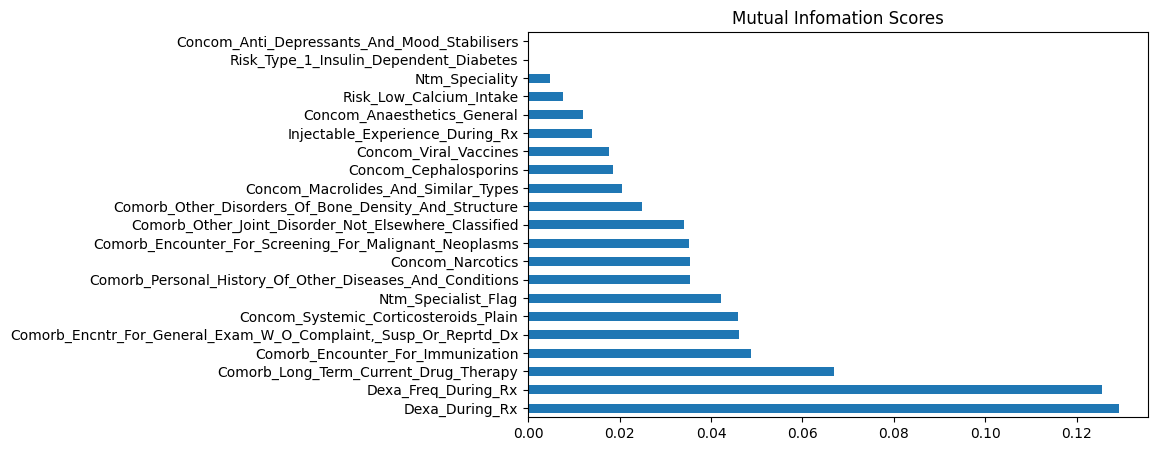

In [62]:
plt.figure(figsize=(8, 5))
mi_scores.plot(kind="barh")
plt.title("Mutual Infomation Scores")
plt.show()